# Navigation Double-DQN

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

# Implementation of Double-DQN

In [12]:
# Definition of the net
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()

        # You just need to call torch.manual_seed(seed), and it will set the seed of the random number generator to a fixed value, 
        # so that when you call for example torch.rand(2), the results will be reproducible.
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [13]:
import numpy as np
import random
from collections import namedtuple, deque
import torch.optim as optim

# let us start with the agent defined previousy
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DDQNAgent():

    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)

        # target network
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)

        # optimizer
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY

        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):

        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """ 
        # transform info torch tensor + float + 4 dim + GPU or CPU
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        # set to.eval() because there is a torch.no_grad below
        self.qnetwork_local.eval()

        # forward pass - get the result
        # torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations 
        # but you won’t be able to backprop (which you don’t want in an eval script).
        with torch.no_grad():
            action_values = self.qnetwork_local(state)

        # prepare for training
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            # argmax cannot be done on GPU so transfert it on cpu()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # random choice
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        # detach() to prevent backprop 
        #
        Q_values      = self.qnetwork_local(states)
        #print('Q_values', Q_values)
        #print('actions', actions)
        next_Q_values = self.qnetwork_local(next_states)
        
        next_Q_state_values = self.qnetwork_target(next_states).detach() 

        Q_value       = Q_values.gather(1, actions)
        
        next_Q_value = next_Q_state_values.gather(1, torch.max(next_Q_values, 1)[1].unsqueeze(1))
        
        expected_Q_value = rewards + gamma * next_Q_value * (1 - dones)

        # Compute loss
        loss = F.mse_loss(expected_Q_value, Q_value)

        # Minimize the loss
        self.optimizer.zero_grad()

        loss.backward()

        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):

        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        #def polyak_update(polyak_factor, target_network, network):
        # for target_param, param in zip(target_network.parameters(), network.parameters()):
        # target_param.data.copy_(polyak_factor*param.data + target_param.data*(1.0 - polyak_factor))

        # copy parameters from local model TO target model
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        # Deques are a generalization of stacks and queues (the name is pronounced “deck” and is short for “double-ended queue”).
        # 0nce a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end. 
        self.memory = deque(maxlen=buffer_size)  

        self.batch_size = batch_size

        # it is like a class
        # Class Experience with five attributes
        # 
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        # create the list
        e = self.experience(state, action, reward, next_state, done)
        #print("ReplayBuffer/Add e: ", e)

        # store in the double-ended queue
        self.memory.append(e)
    
    def sample(self):

        """Randomly sample a batch of experiences from memory."""
        # get an array of experiences

        experiences = random.sample(self.memory, k=self.batch_size)
        #print("ReplayBuffer/sample experiences: ", experiences)

        # vstack Stack arrays in sequence vertically (row wise).
        # This is equivalent to concatenation along the first axis after 1-D arrays of shape (N,) have been reshaped to (1,N). Rebuilds arrays divided by vsplit.
        #
        # then transform into torch tensor
        #
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        #print("ReplayBuffer/sample states: ", states)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

start Double-DQN
Here we go
Episode 100	Average Score: 6.66
Episode 200	Average Score: 10.68
Episode 297	Average Score: 13.04
Environment solved in 197 episodes!	Average Score: 13.04


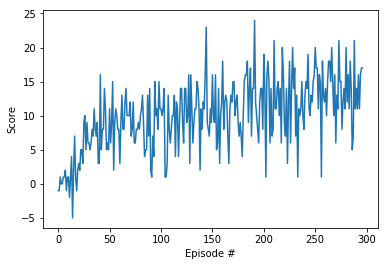

In [14]:
import matplotlib.pyplot as plt

def ddqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    agent = DDQNAgent(state_size=37, action_size=4, seed=0)
    
    print("Here we go")
    
    for i_episode in range(1, n_episodes+1):
        
        # pick up one state randomly or same - depends on the implementation of env.reset() which depends
        # on the "game"
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        
        state = env_info.vector_observations[0]

        score = 0
        
        for t in range(max_t):
            
            # choose action using qnetwork_local()
            # A = agent(S)
            action = agent.act(state, eps)
            
            # print("LOOP action: ", action)
            # select next actions S prime based on the selected action
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]   # get the reward
            done = env_info.local_done[0]  # succeed or not
            
            #print("LOOP next_state, reward, done ", next_state, " , ", reward, " , ", done)
            # store in memory and after a given number of iteration - samples and learn
            
            # AGENT (S, A, R, Sprime, Done)
            agent.step(state, action, reward, next_state, done)
            
            #print("LOOP next_state: ", next_state)
            
            state = next_state
            
            score += reward
            
            if done:
                break 
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon for the esp-greedy policy
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_ddqn_256.pth')
            break
    return scores


print("start Double-DQN")
scores_ddqn = ddqn(eps_decay = 0.90)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_ddqn)), scores_ddqn)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

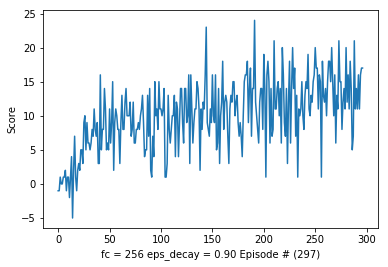

In [15]:
# plot the scores = 297
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_ddqn)), scores_ddqn)
plt.ylabel('Score')
plt.xlabel('fc = 256 eps_decay = 0.90 Episode # (297)')
plt.show()

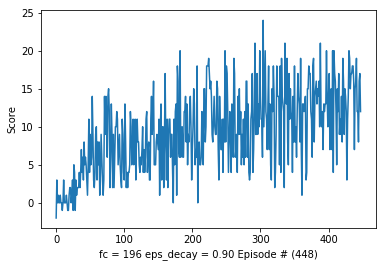

In [10]:
# plot the scores = 448
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_ddqn)), scores_ddqn)
plt.ylabel('Score')
plt.xlabel('fc = 196 eps_decay = 0.90 Episode # (448)')
plt.show()

In [16]:
# values 297
print(scores_ddqn)

[-1.0, -1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, -1.0, 1.0, 1.0, -2.0, 1.0, 4.0, -5.0, 2.0, 7.0, 1.0, -1.0, 2.0, 3.0, 2.0, 5.0, 5.0, 3.0, 9.0, 10.0, 5.0, 9.0, 6.0, 6.0, 5.0, 6.0, 8.0, 7.0, 11.0, 8.0, 7.0, 9.0, 3.0, 3.0, 16.0, 5.0, 8.0, 8.0, 14.0, 11.0, 5.0, 6.0, 5.0, 11.0, 6.0, 9.0, 15.0, 2.0, 9.0, 11.0, 10.0, 8.0, 8.0, 3.0, 9.0, 13.0, 8.0, 8.0, 12.0, 14.0, 10.0, 10.0, 10.0, 12.0, 7.0, 8.0, 12.0, 6.0, 6.0, 8.0, 8.0, 9.0, 8.0, 10.0, 11.0, 13.0, 9.0, 4.0, 5.0, 5.0, 13.0, 7.0, 14.0, 2.0, 1.0, 7.0, 4.0, 15.0, 10.0, 11.0, 8.0, 15.0, 11.0, 11.0, 10.0, 11.0, 14.0, 1.0, 1.0, 3.0, 13.0, 8.0, 6.0, 8.0, 10.0, 10.0, 13.0, 4.0, 12.0, 11.0, 4.0, 9.0, 14.0, 14.0, 9.0, 6.0, 14.0, 14.0, 9.0, 10.0, 16.0, 3.0, 16.0, 11.0, 6.0, 9.0, 11.0, 11.0, 15.0, 14.0, 11.0, 2.0, 11.0, 8.0, 12.0, 11.0, 16.0, 23.0, 9.0, 8.0, 7.0, 11.0, 9.0, 16.0, 10.0, 9.0, 16.0, 5.0, 6.0, 14.0, 3.0, 10.0, 12.0, 18.0, 8.0, 12.0, 13.0, 12.0, 7.0, 3.0, 11.0, 13.0, 12.0, 15.0, 15.0, 10.0, 12.0, 13.0, 9.0, 7.0, 9.0, 7.0, 4.0, 10.0, 15.0, 16.0, 1